In [31]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
#from cryoem.quaternions import euler2quaternion, d_q
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude, plot_distances_count, plot_angles_count
from cryoem.conversions import distance_difference
import ipyvolume as ipv
from IPython import display as IPyDisplay
import time
from cryoem.conversions import euler2quaternion, quaternion2euler, d_q

In [22]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [23]:
ap = np.load("data/predicted_angles2.npy")
# #ap = np.load("data/predicted_angles_var0.8.npy")
# ap = np.load("data/predicted_angles_var0.npy")

Mean `quaternion` distance between true and predicted values: 1.915 rad (109.726 degrees)


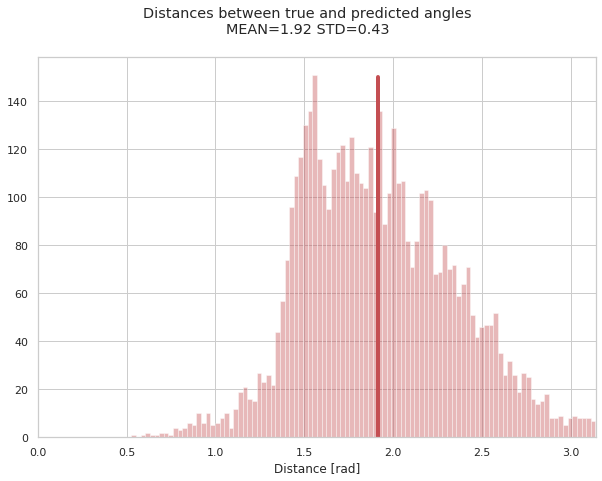

In [24]:
distance_difference(angles_predicted=ap, angles_true=angles_true);
plot_distances_count(ap, angles_true);

In [18]:
# # MIRROR X
# apt = np.zeros(ap.shape)
# for i, a in enumerate(ap):
#     apt[i] = np.array([-(a[0]+np.pi)%(2*np.pi), (a[1]+np.pi)%np.pi, a[2]%(2*np.pi)])

# distance_difference(angles_predicted=apt, angles_true=angles_true);
# plot_distances_count(apt, angles_true);

In [19]:
# np.savez(f"{PROTEIN}_projections_and_angles", projections, ap)

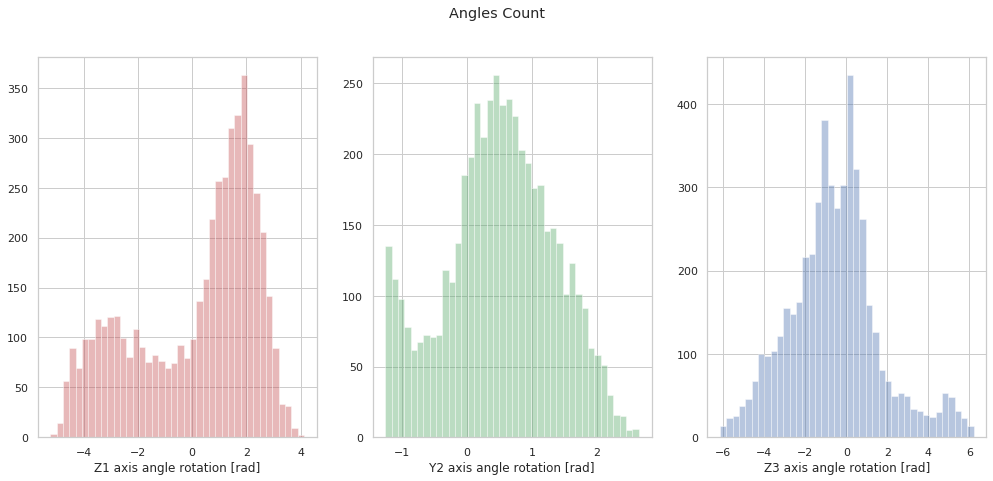

In [26]:
sns.set(style="white", color_codes=True)
sns.set(style="whitegrid")

# for i, a in enumerate(ap):
#     ap[i] = np.array([a[0]%(2*np.pi), a[1]%np.pi, a[2]%(2*np.pi)])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
# axs[0].set_xlim(0,2*np.pi)
# axs[1].set_xlim(0,np.pi)
# axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Angles Count")

sns.distplot(ap[:,0]-angles_true[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(ap[:,1]-angles_true[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(ap[:,2]-angles_true[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b")
plt.show()

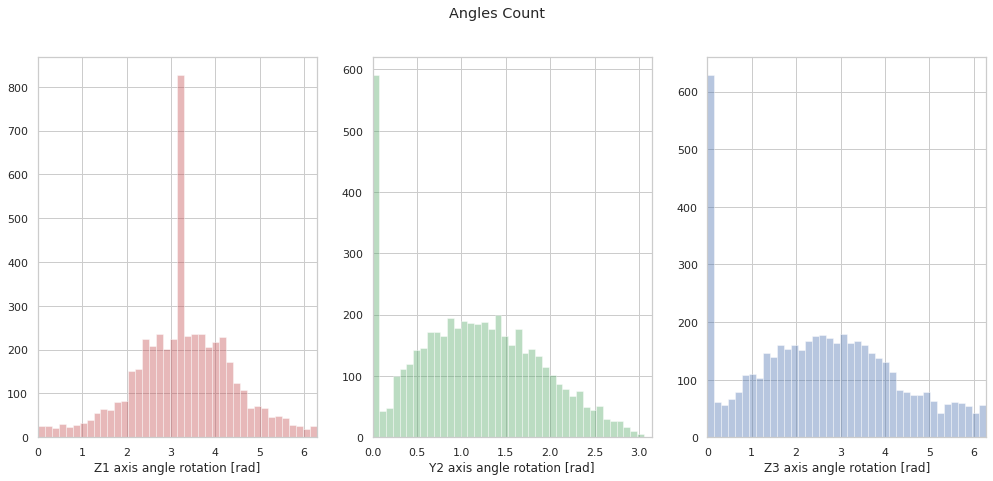

In [25]:
plot_angles_count(ap)

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R_1 \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} R_2 \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [29]:
# update_angles([1,1,1,1], [tf.Variable([0.0,0.0,0.0,0.0,0.0,0.0])], angles_true, transposed=True)

In [32]:
e1 = tf.convert_to_tensor([[0, 1, 0]], dtype=tf.float64)
e2 = tf.convert_to_tensor([[0, 0, 0]], dtype=tf.float64)
q1 = euler2quaternion(e1)
q2 = euler2quaternion(e2)
d_q(q1, q2).numpy()[0]

1.0000000000000027

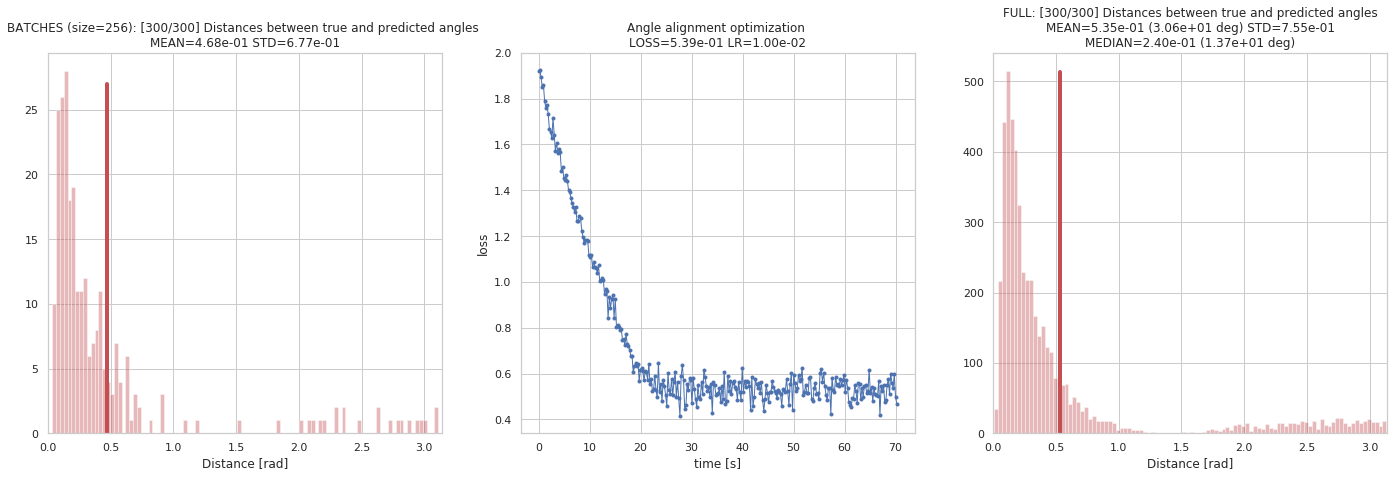

step 30/300 (8s): loss = 1.62e+00
step 60/300 (15s): loss = 1.12e+00
step 90/300 (22s): loss = 7.30e-01
step 120/300 (29s): loss = 5.44e-01
step 150/300 (37s): loss = 5.32e-01
step 180/300 (43s): loss = 5.36e-01
step 210/300 (51s): loss = 5.22e-01
step 240/300 (58s): loss = 5.50e-01
step 270/300 (65s): loss = 5.28e-01
step 300/300 (72s): loss = 5.30e-01



In [30]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap,
                         transposed=False)

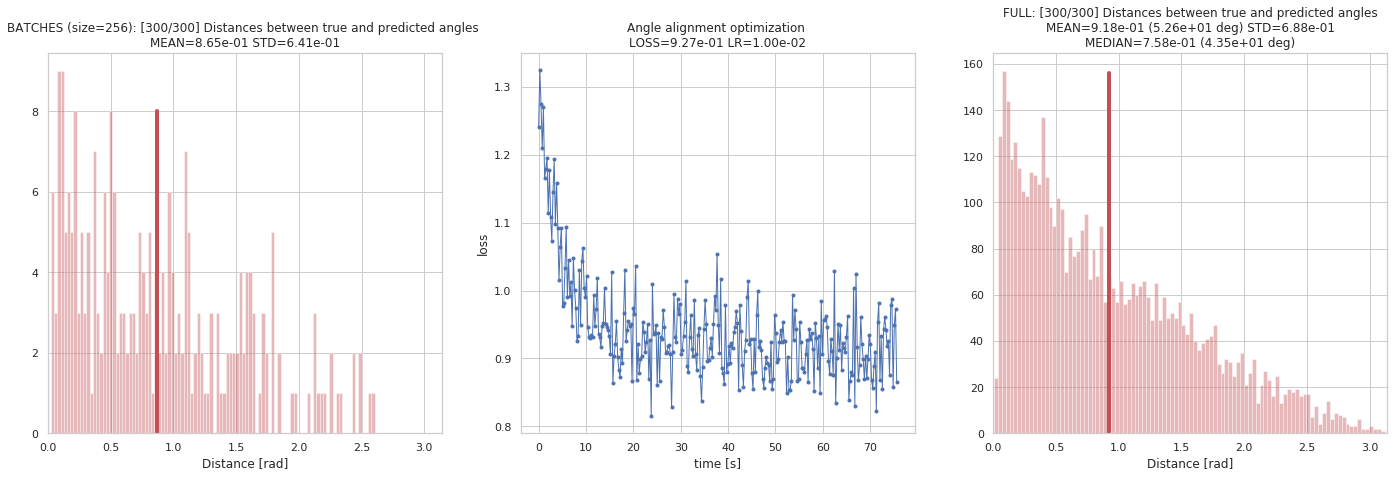

step 30/300 (7s): loss = 1.11e+00
step 60/300 (15s): loss = 9.68e-01
step 90/300 (23s): loss = 9.30e-01
step 120/300 (31s): loss = 9.26e-01
step 150/300 (39s): loss = 9.27e-01
step 180/300 (47s): loss = 9.24e-01
step 210/300 (55s): loss = 9.10e-01
step 240/300 (63s): loss = 9.14e-01
step 270/300 (70s): loss = 9.14e-01
step 300/300 (77s): loss = 9.13e-01



In [51]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

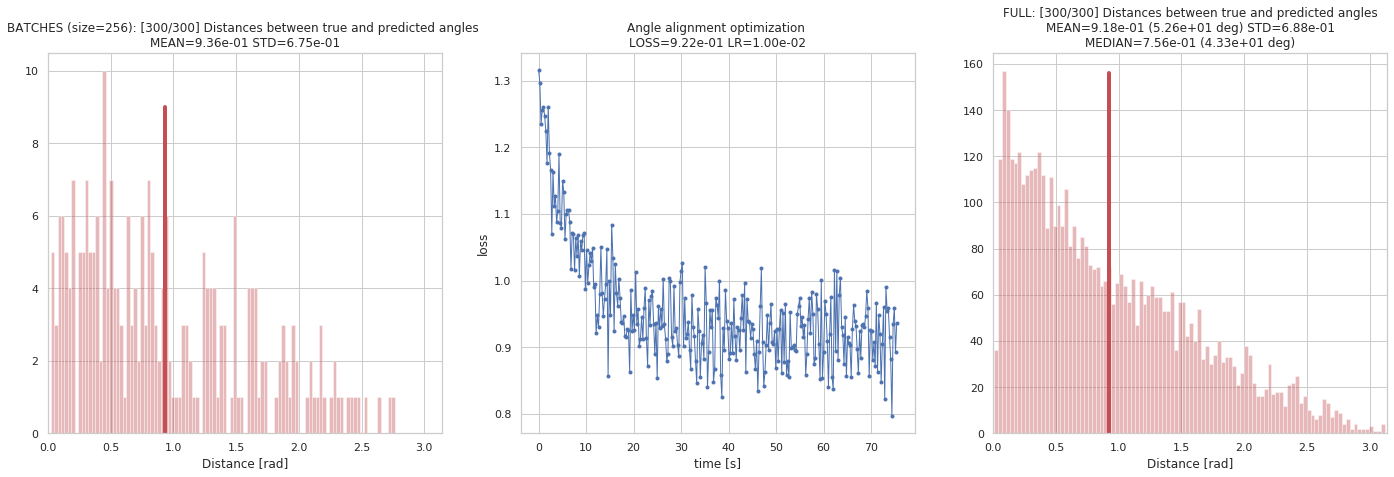

step 30/300 (7s): loss = 1.15e+00
step 60/300 (15s): loss = 1.01e+00
step 90/300 (23s): loss = 9.53e-01
step 120/300 (31s): loss = 9.35e-01
step 150/300 (39s): loss = 9.20e-01
step 180/300 (47s): loss = 9.25e-01
step 210/300 (54s): loss = 9.08e-01
step 240/300 (62s): loss = 9.23e-01
step 270/300 (70s): loss = 9.18e-01
step 300/300 (77s): loss = 9.17e-01



In [52]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, 1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

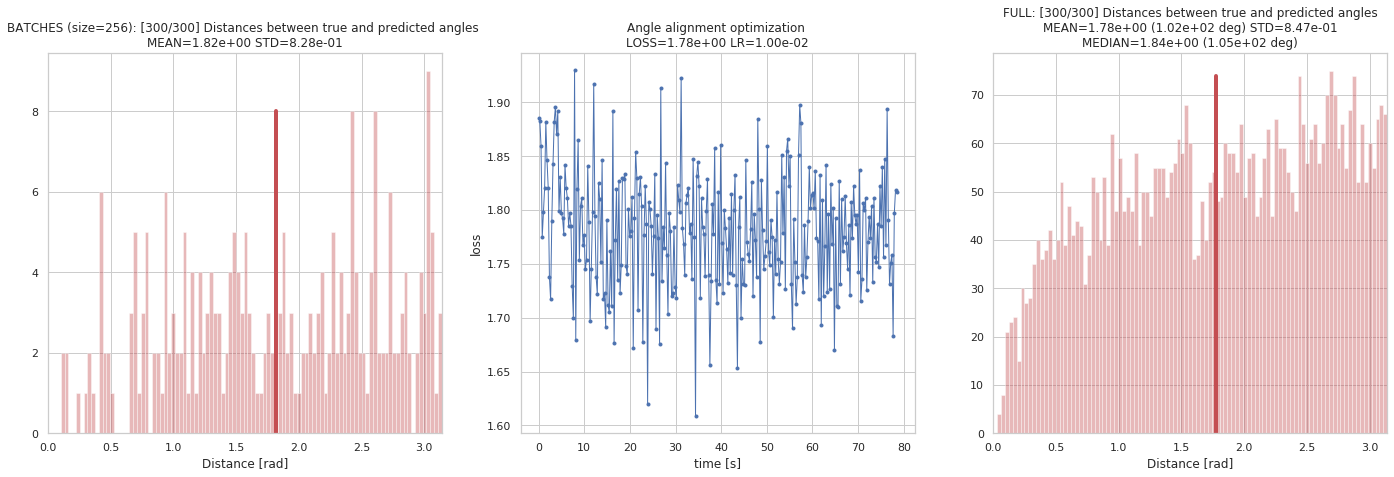

step 30/300 (8s): loss = 1.82e+00
step 60/300 (16s): loss = 1.78e+00
step 90/300 (24s): loss = 1.78e+00
step 120/300 (32s): loss = 1.77e+00
step 150/300 (40s): loss = 1.78e+00
step 180/300 (48s): loss = 1.77e+00
step 210/300 (56s): loss = 1.78e+00
step 240/300 (64s): loss = 1.78e+00
step 270/300 (72s): loss = 1.77e+00
step 300/300 (80s): loss = 1.78e+00



In [53]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap,
                                            transposed=True)

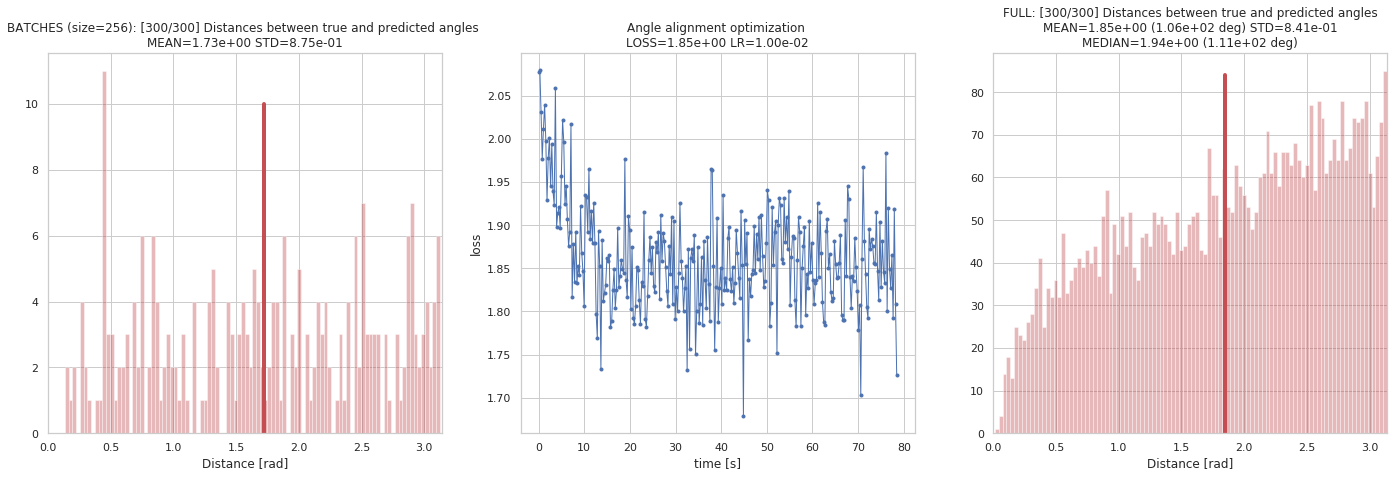

step 30/300 (8s): loss = 1.96e+00
step 60/300 (17s): loss = 1.86e+00
step 90/300 (25s): loss = 1.84e+00
step 120/300 (33s): loss = 1.85e+00
step 150/300 (41s): loss = 1.84e+00
step 180/300 (48s): loss = 1.84e+00
step 210/300 (56s): loss = 1.88e+00
step 240/300 (64s): loss = 1.85e+00
step 270/300 (72s): loss = 1.85e+00
step 300/300 (80s): loss = 1.86e+00



In [54]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

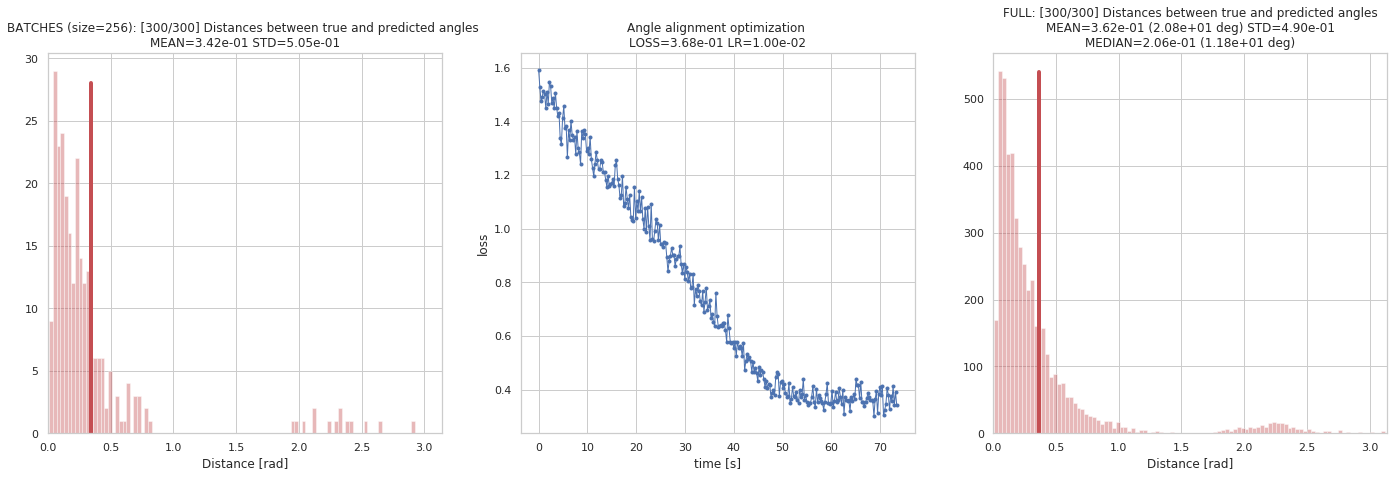

step 30/300 (7s): loss = 1.44e+00
step 60/300 (15s): loss = 1.27e+00
step 90/300 (22s): loss = 1.12e+00
step 120/300 (30s): loss = 9.49e-01
step 150/300 (37s): loss = 7.58e-01
step 180/300 (45s): loss = 5.73e-01
step 210/300 (52s): loss = 4.26e-01
step 240/300 (60s): loss = 3.70e-01
step 270/300 (68s): loss = 3.72e-01
step 300/300 (75s): loss = 3.63e-01



In [55]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, 1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

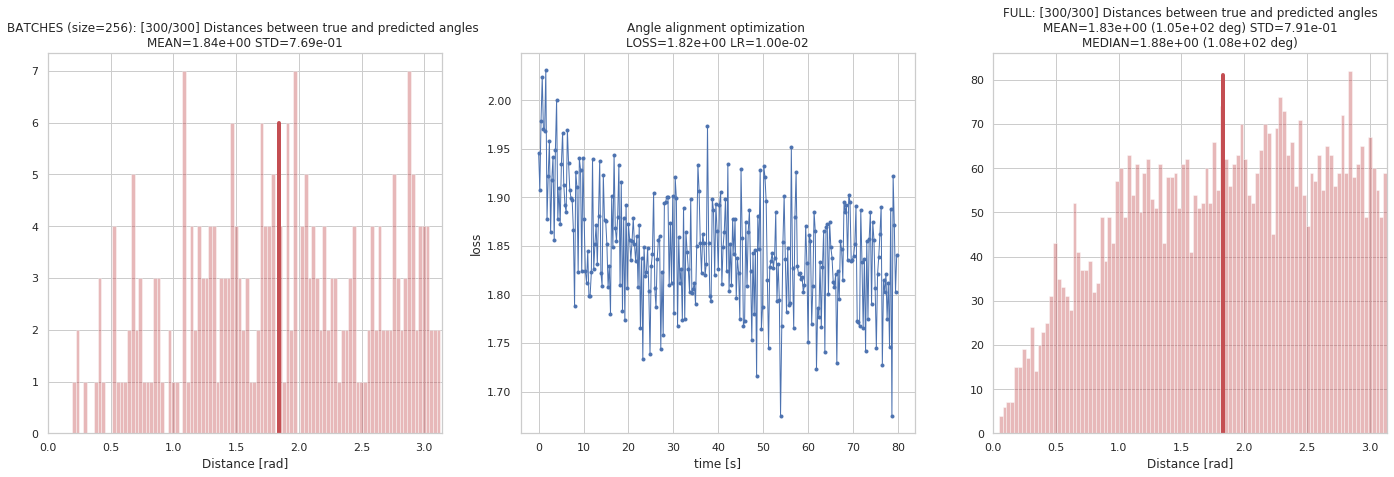

step 30/300 (7s): loss = 1.93e+00
step 60/300 (15s): loss = 1.86e+00
step 90/300 (24s): loss = 1.85e+00
step 120/300 (32s): loss = 1.84e+00
step 150/300 (40s): loss = 1.85e+00
step 180/300 (48s): loss = 1.84e+00
step 210/300 (57s): loss = 1.83e+00
step 240/300 (65s): loss = 1.83e+00
step 270/300 (73s): loss = 1.84e+00
step 300/300 (82s): loss = 1.82e+00



In [56]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

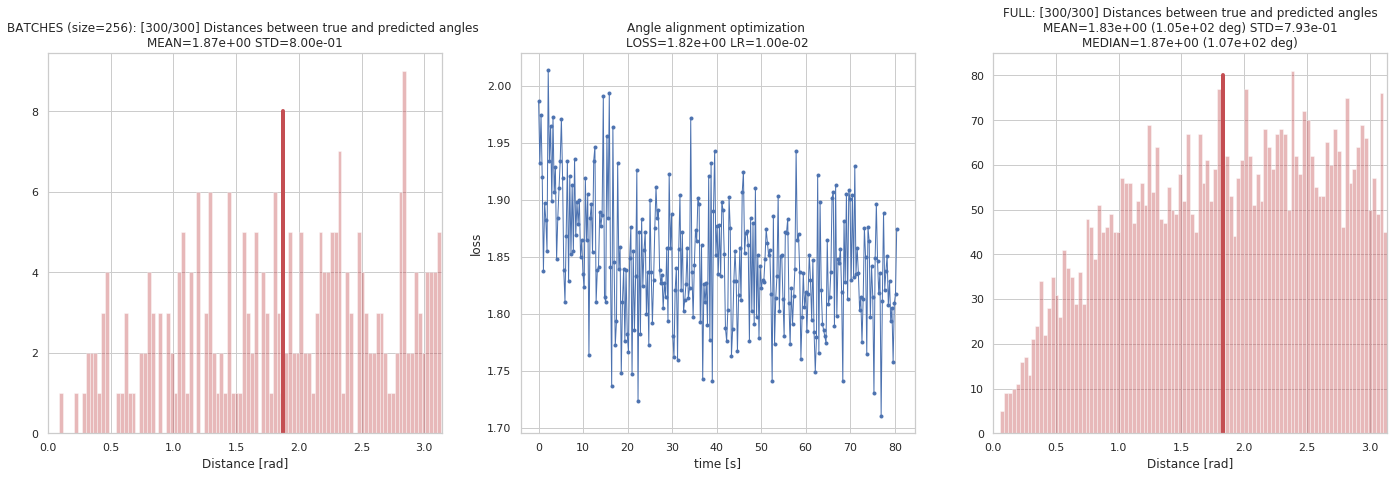

step 30/300 (8s): loss = 1.91e+00
step 60/300 (17s): loss = 1.88e+00
step 90/300 (24s): loss = 1.83e+00
step 120/300 (32s): loss = 1.84e+00
step 150/300 (40s): loss = 1.84e+00
step 180/300 (49s): loss = 1.84e+00
step 210/300 (57s): loss = 1.84e+00
step 240/300 (66s): loss = 1.82e+00
step 270/300 (74s): loss = 1.85e+00
step 300/300 (82s): loss = 1.82e+00



In [57]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

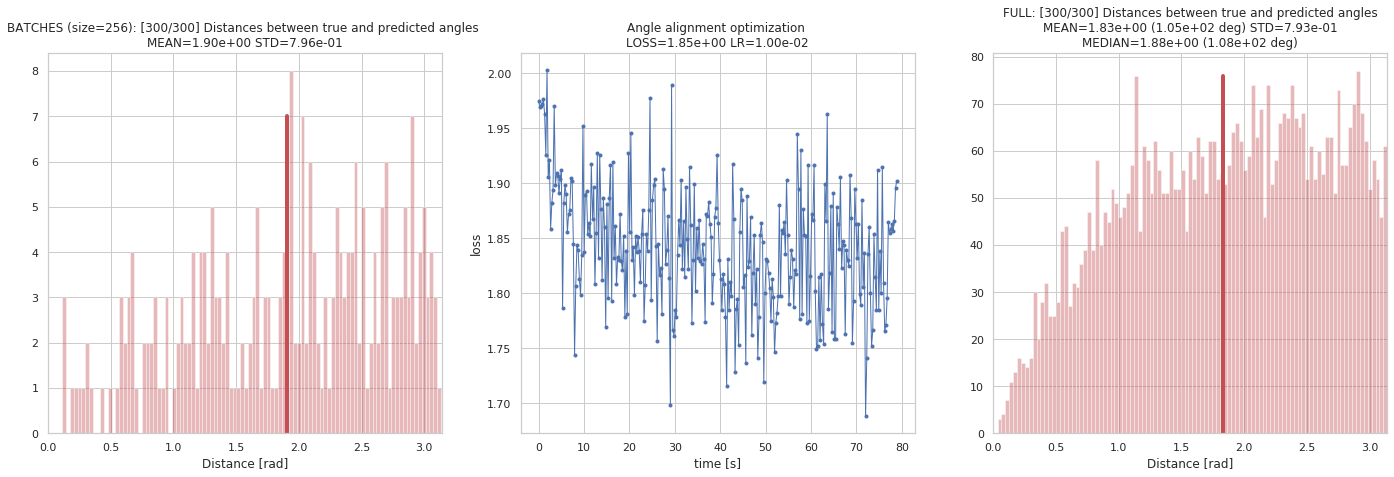

step 30/300 (8s): loss = 1.91e+00
step 60/300 (16s): loss = 1.85e+00
step 90/300 (24s): loss = 1.84e+00
step 120/300 (32s): loss = 1.84e+00
step 150/300 (40s): loss = 1.85e+00
step 180/300 (48s): loss = 1.82e+00
step 210/300 (57s): loss = 1.82e+00
step 240/300 (65s): loss = 1.83e+00
step 270/300 (73s): loss = 1.84e+00
step 300/300 (81s): loss = 1.82e+00



In [58]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

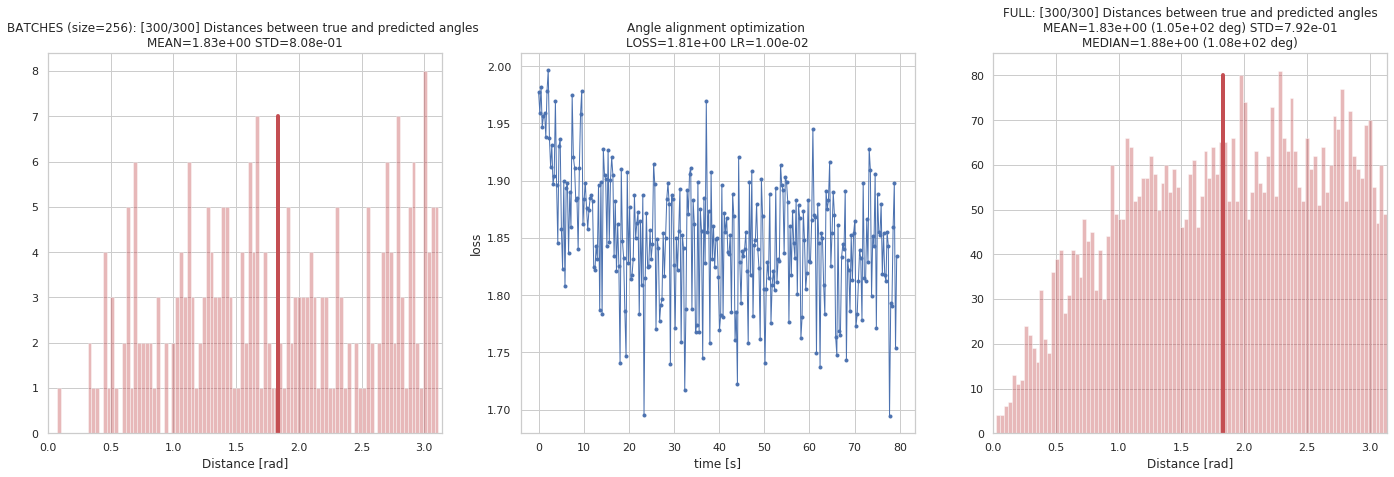

step 30/300 (9s): loss = 1.92e+00
step 60/300 (17s): loss = 1.88e+00
step 90/300 (25s): loss = 1.84e+00
step 120/300 (33s): loss = 1.84e+00
step 150/300 (41s): loss = 1.84e+00
step 180/300 (49s): loss = 1.83e+00
step 210/300 (57s): loss = 1.84e+00
step 240/300 (66s): loss = 1.84e+00
step 270/300 (73s): loss = 1.83e+00
step 300/300 (81s): loss = 1.84e+00



In [59]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

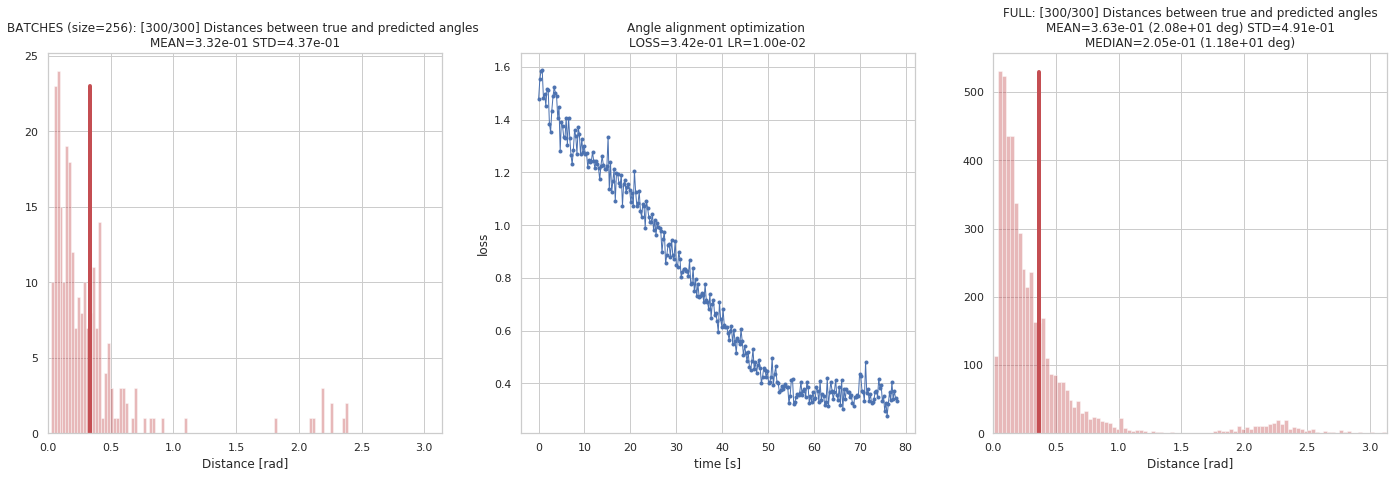

step 30/300 (8s): loss = 1.43e+00
step 60/300 (16s): loss = 1.26e+00
step 90/300 (24s): loss = 1.13e+00
step 120/300 (32s): loss = 9.51e-01
step 150/300 (40s): loss = 7.56e-01
step 180/300 (48s): loss = 5.69e-01
step 210/300 (56s): loss = 4.24e-01
step 240/300 (64s): loss = 3.62e-01
step 270/300 (72s): loss = 3.60e-01
step 300/300 (80s): loss = 3.56e-01



In [60]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, -1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

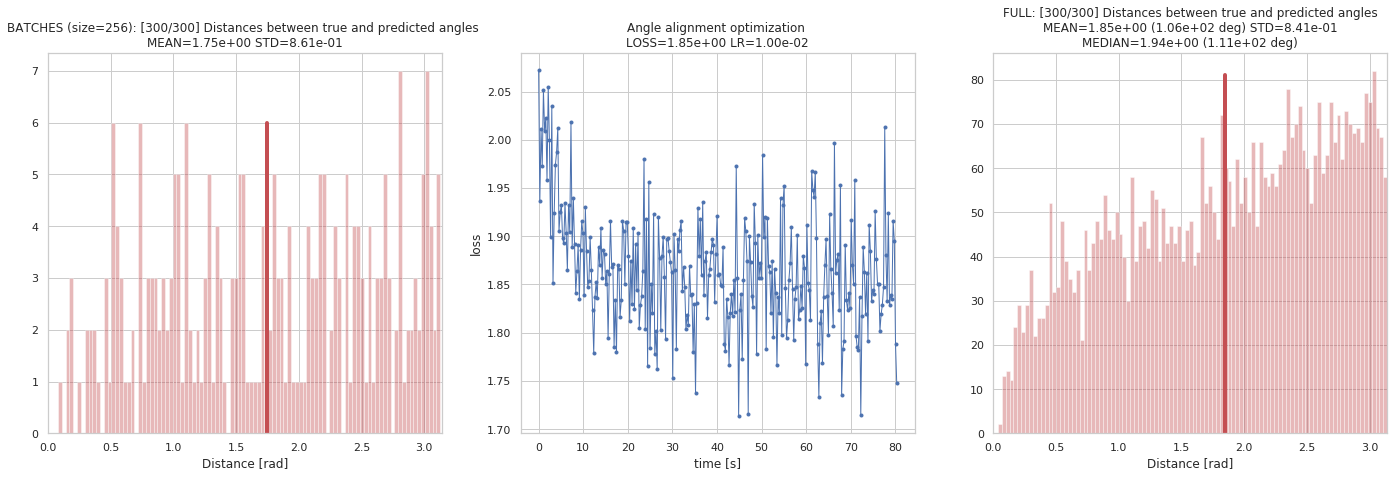

step 30/300 (8s): loss = 1.96e+00
step 60/300 (17s): loss = 1.86e+00
step 90/300 (25s): loss = 1.86e+00
step 120/300 (33s): loss = 1.86e+00
step 150/300 (41s): loss = 1.85e+00
step 180/300 (49s): loss = 1.84e+00
step 210/300 (58s): loss = 1.86e+00
step 240/300 (66s): loss = 1.85e+00
step 270/300 (74s): loss = 1.85e+00
step 300/300 (82s): loss = 1.86e+00



In [61]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

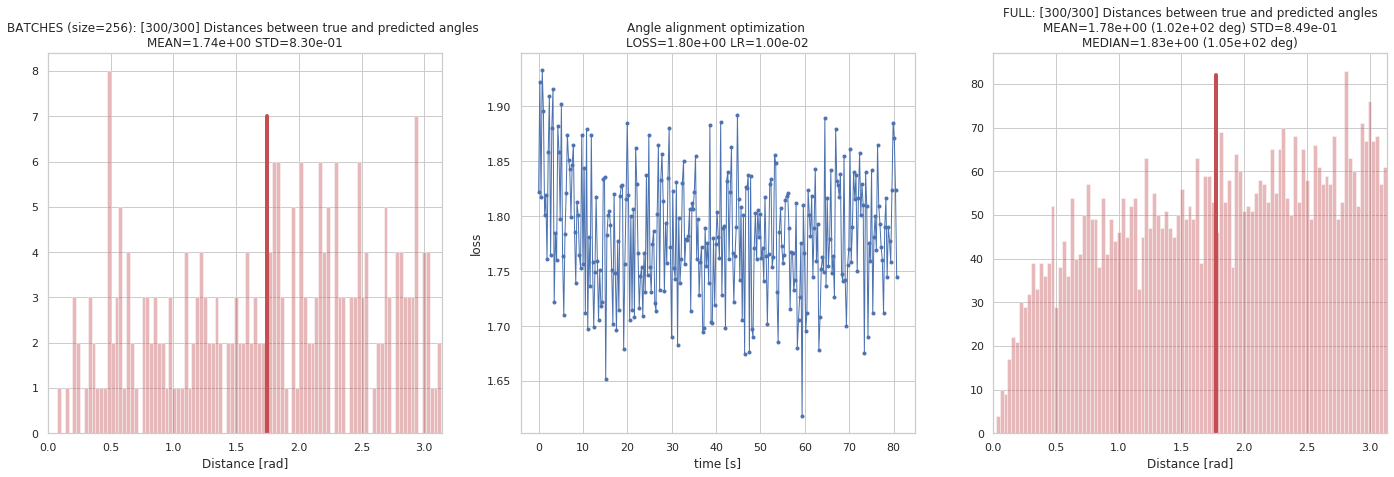

step 30/300 (8s): loss = 1.83e+00
step 60/300 (16s): loss = 1.77e+00
step 90/300 (25s): loss = 1.77e+00
step 120/300 (33s): loss = 1.78e+00
step 150/300 (41s): loss = 1.77e+00
step 180/300 (49s): loss = 1.78e+00
step 210/300 (58s): loss = 1.78e+00
step 240/300 (66s): loss = 1.75e+00
step 270/300 (74s): loss = 1.79e+00
step 300/300 (83s): loss = 1.79e+00



In [62]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

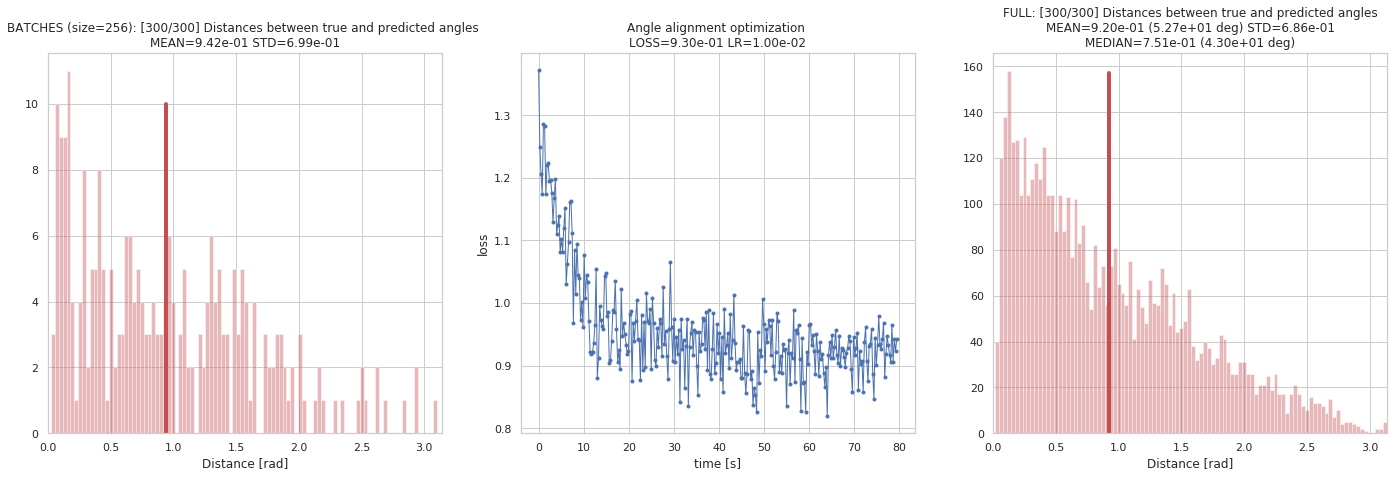

step 30/300 (8s): loss = 1.17e+00
step 60/300 (16s): loss = 9.93e-01
step 90/300 (25s): loss = 9.50e-01
step 120/300 (33s): loss = 9.49e-01
step 150/300 (41s): loss = 9.29e-01
step 180/300 (49s): loss = 9.20e-01
step 210/300 (57s): loss = 9.20e-01
step 240/300 (65s): loss = 9.15e-01
step 270/300 (73s): loss = 9.17e-01
step 300/300 (81s): loss = 9.23e-01



In [63]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, -1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

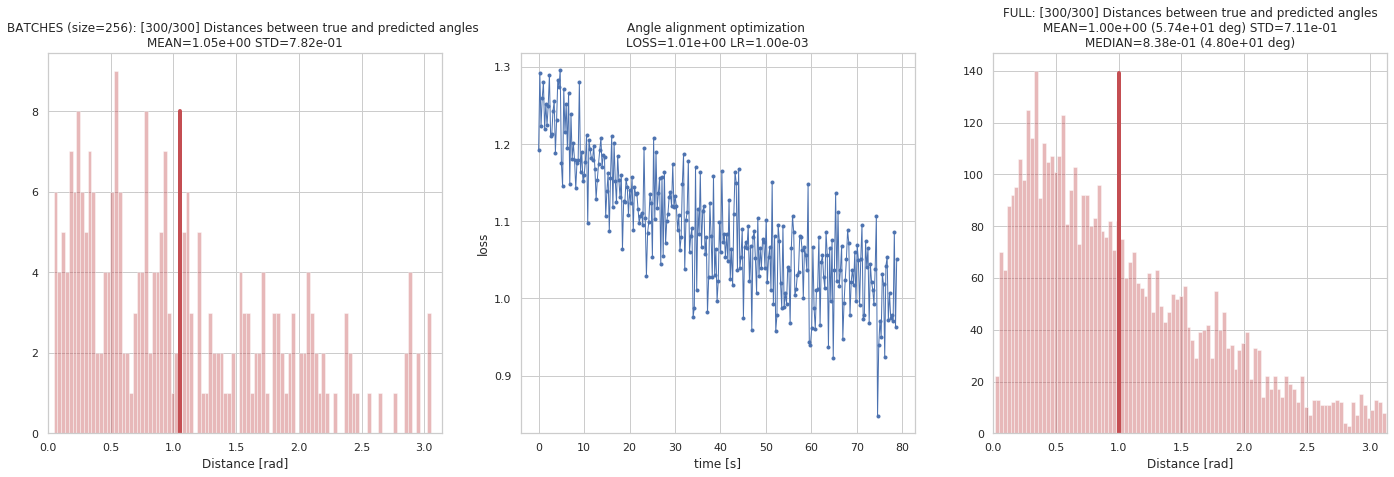

step 30/300 (8s): loss = 1.23e+00
step 60/300 (15s): loss = 1.17e+00
step 90/300 (23s): loss = 1.14e+00
step 120/300 (31s): loss = 1.12e+00
step 150/300 (39s): loss = 1.08e+00
step 180/300 (46s): loss = 1.07e+00
step 210/300 (54s): loss = 1.04e+00
step 240/300 (64s): loss = 1.03e+00
step 270/300 (72s): loss = 1.03e+00
step 300/300 (81s): loss = 1.00e+00



In [65]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, -1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.001, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

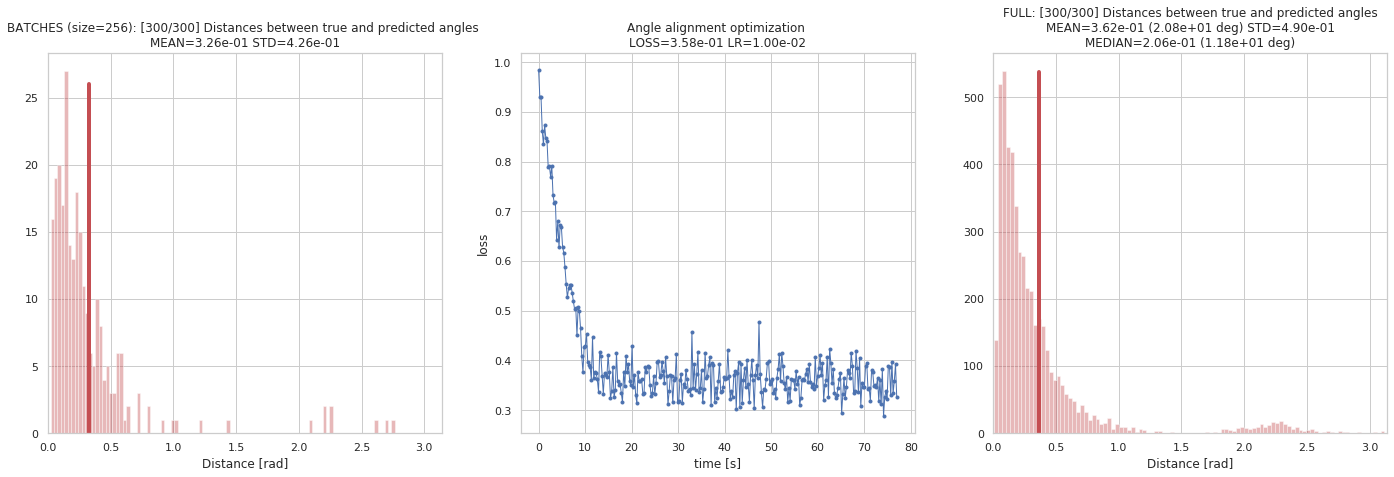

step 30/300 (8s): loss = 7.17e-01
step 60/300 (16s): loss = 4.10e-01
step 90/300 (24s): loss = 3.58e-01
step 120/300 (32s): loss = 3.62e-01
step 150/300 (40s): loss = 3.63e-01
step 180/300 (48s): loss = 3.59e-01
step 210/300 (56s): loss = 3.64e-01
step 240/300 (63s): loss = 3.61e-01
step 270/300 (71s): loss = 3.63e-01
step 300/300 (79s): loss = 3.53e-01



In [66]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, -1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

In [3]:
mat = update_angles(m, rotation, apt)
mat

In [4]:
distance_difference(angles_predicted=mat, angles_true=angles_true);
plot_distances_count(mat, angles_true);

In [33]:
np.savez(f"../3-reconstruction/data/{PROTEIN}_projections_and_angles_var0.8_perfect_aligned", projections, mat)